# 4.3 - Classificação
#### Considere os países das quatro regiões anteriormente definidas.

Western Europe: Austria, Belgium, France, Germany, Netherlands, Switzerland

Eastern Europe: Poland, Czechia, Hungary

Southern Europe: Greece, Spain, Italy, Portugal

Northern Europe: Sweden, Denmark, Finland

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [384]:
df = pd.read_csv("AIRPOL_data.csv", delimiter=';')

# 1. Definir países por região
REGIOES = {
    'Western Europe': ['Austria', 'Belgium', 'France', 'Germany', 'Netherlands', 'Switzerland'],
    'Eastern Europe': ['Poland', 'Czechia', 'Hungary'],
    'Southern Europe': ['Greece', 'Spain', 'Italy', 'Portugal'],
    'Northern Europe': ['Sweden', 'Denmark', 'Norway', 'Finland']
}

# 2. Lista única de países válidos (sem repetições)
PAISES_VALIDOS = [country for sublist in REGIOES.values() for country in sublist]

# 4. Filtrar linhas:
#    - Países nas regiões definidas
#    - retirar "All countries"
#    - NUTS_Code com 5+ caracteres
df = df[
    (df['Country'].isin(PAISES_VALIDOS)) &
    (df['Country'] != "All countries") &
    (df['NUTS_Code'].str.len() >= 5)
]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30305 entries, 133 to 47819
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       30305 non-null  object 
 1   NUTS_Code                     30305 non-null  object 
 2   Air_Pollutant                 30305 non-null  object 
 3   Outcome                       30305 non-null  object 
 4   Affected_Population           30305 non-null  object 
 5   Populated_Area[km2]           30305 non-null  object 
 6   Air_Pollution_Average[ug/m3]  30305 non-null  object 
 7   Value                         30305 non-null  object 
 8   Unnamed: 8                    0 non-null      float64
 9   Unnamed: 9                    0 non-null      float64
 10  Unnamed: 10                   0 non-null      float64
 11  Unnamed: 11                   0 non-null      float64
 12  Unnamed: 12                   0 non-null      float64
 13  Unna

In [385]:
toDrop = ['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
          'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
          'Unnamed: 14', 'Unnamed: 15']

df.drop(columns=toDrop, axis=1, inplace = True)

print(f"Shape before deleting duplicates {df.shape}")
df = df.drop_duplicates()
print(f"Shape after deleting duplicates {df.shape}")

df.describe()



Shape before deleting duplicates (30305, 8)
Shape after deleting duplicates (27997, 8)


,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
count,27997,27997,27997,27997,27997,27997,27997,27997
unique,17,1045,3,6,3127,1116,511,1185
top,Germany,AT333,PM2.5,Diabetes Mellitus,"27071,00","383,90","7,80","0,00"
freq,10968,29,17486,6034,25,82,724,3390


In [386]:
predictors= ['Country', 'NUTS_Code', 'Air_Pollutant', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]']
print(predictors)

['Country', 'NUTS_Code', 'Air_Pollutant', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]']


In [387]:
numeric_columns = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']
for col in numeric_columns:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

In [388]:
#df.head(25)

In [389]:
df_grouped = df.groupby(['Country', 'NUTS_Code', 'Air_Pollutant', 'Outcome']).agg({
    'Affected_Population': 'mean',
    'Populated_Area[km2]': 'mean',
    'Air_Pollution_Average[ug/m3]': 'mean',
    'Value': 'sum'
}).reset_index()  # reset_index() para transformar as colunas de agrupamento em colunas normais

# Mostrar o resultado
#print(df_grouped)

# Se quiser salvar em um novo arquivo CSV:
#grouped.to_csv("AIRPOL_grouped.csv", index=False, decimal=",", float_format='%.1f')

#grouped.to_csv("AIRPOL_grouped_5nutscode.csv", index=False, decimal=",", float_format='%.1f')

#grouped.to_csv("AIRPOL_grouped_4regioes.csv", index=False, decimal=",", float_format='%.1f')


#### 1. Derive um novo atributo RespDisease que separa as doenças em respiratórias ('Asthma' 'Chronic obstructive pulmonary disease') e não respiratórias.


Classificação de doenças:
                                 Outcome      RespDisease
0                                 Asthma      Respiratory
1                      Diabetes Mellitus  Non-Respiratory
2                                 Stroke  Non-Respiratory
3  Chronic obstructive pulmonary disease      Respiratory
7                 Ischemic heart disease  Non-Respiratory
8                            Lung cancer  Non-Respiratory
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       10450 non-null  object 
 1   NUTS_Code                     10450 non-null  object 
 2   Air_Pollutant                 10450 non-null  object 
 3   Outcome                       10450 non-null  object 
 4   RespDisease                   10450 non-null  object 
 5   Affected_Population           10450 non-n

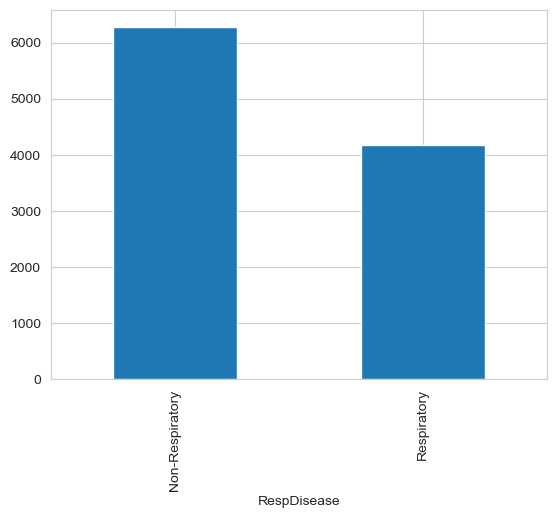

In [390]:
# Lista de doenças respiratórias (case-insensitive)
doencas_respiratorias = ['asthma', 'chronic obstructive pulmonary disease']

# Derivar a nova coluna baseada na coluna 'Outcome'
df_grouped['RespDisease'] = df_grouped['Outcome'].str.lower().apply(
    lambda x: 'Respiratory' if any(doenca in x for doenca in doencas_respiratorias)
              else 'Non-Respiratory'
)

# Verificação rápida da classificação
print("\nClassificação de doenças:")
print(df_grouped[['Outcome', 'RespDisease']].drop_duplicates())

# Reordenar colunas (opcional)
cols = df_grouped.columns.tolist()
cols.insert(4, cols.pop(cols.index('RespDisease')))  # Move 'RespDisease' após 'Outcome'
df_grouped = df_grouped[cols]

# Gravar o resultado final
#grouped.to_csv("AIRPOL_final_with_RespDisease.csv", index=False, decimal=".", sep=';', float_format='%.1f')

# Mostrar as primeiras linhas com a nova coluna
#print("\nDataFrame final com RespDisease:")
#print(grouped.head())

df_grouped.RespDisease.value_counts().plot.bar()

df_grouped.info()

#### 2. Usando o método k-fold cross validation desenvolva modelos de previsão de RespDisease usando os seguintes métodos:

K-fold cross validation (k=10) accuracy mean (std) 0.777(0.019)

                  precision    recall  f1-score   support

Non-Respiratory       0.81      0.82      0.82      4389
    Respiratory       0.73      0.71      0.72      2926

       accuracy                           0.78      7315
      macro avg       0.77      0.77      0.77      7315
   weighted avg       0.78      0.78      0.78      7315


Final model: 


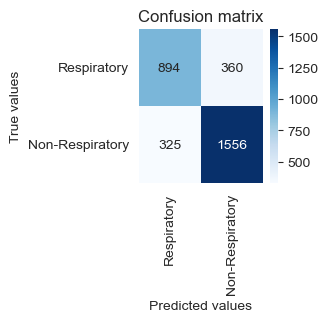


                  precision    recall  f1-score   support

    Respiratory       0.73      0.71      0.72      1254
Non-Respiratory       0.81      0.83      0.82      1881

       accuracy                           0.78      3135
      macro avg       0.77      0.77      0.77      3135
   weighted avg       0.78      0.78      0.78      3135



In [391]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split

def confMatrix(y_test,y_pred, labels):
    cm = confusion_matrix(y_test,y_pred, labels=labels)
    plt.figure(figsize=(2,2))

    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', cbar='False',xticklabels=labels, yticklabels=labels)

    plt.title('Confusion matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.show()

def classifmodelEval(y_test, y_pred, labels):
    confMatrix(y_test, y_pred, labels=labels)
    print('\n', classification_report(y_test, y_pred,labels=labels))

def split_into_k_folds(data, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    folds = []
    for train_idx, test_idx in kf.split(data):
        folds.append((train_idx, test_idx))
    return folds

# 1º - dividir dados em treino e teste

features = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']

y=df_grouped['RespDisease']

X=df_grouped[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#print(f"Train set goal attribute:  {y_train.value_counts(normalize=True)}")
#print(f"Test set goal attribute:  {y_test.value_counts(normalize=True)}")

# 2º Correr o K-fold cross validation no set de treino

clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)

k=10
kfolds = split_into_k_folds(X_train, k)

scores=[]
pred_folds=[]
tst_folds=[]

for train_idx, test_idx in kfolds:
    X_kftrain, y_kftrain = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_kftest, y_kftest = X_train.iloc[test_idx], y_train.iloc[test_idx]


    # treinar modelo com dados de treino
    dtm = clf.fit(X_kftrain, y_kftrain)

    # fazer previsões com dados de teste
    y_pred = dtm.predict(X_kftest)

    pred_folds.append(y_pred)
    tst_folds.append(y_kftest)

    accuracy = accuracy_score(y_kftest, y_pred)
    scores.append(accuracy)


# 3  - Avaliar os modelos

print(f"K-fold cross validation (k=10) accuracy mean (std) {round(np.mean(scores),3)}({round(np.std(scores),3)})")
print('\n', classification_report(np.concatenate(tst_folds), np.concatenate(pred_folds)))

# 4 - Após CV, treinar o modelo no set de treino e avaliar no set de teste

final_model = clf.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)
print("\nFinal model: ")
classifmodelEval(y_test, y_test_pred, ['Respiratory','Non-Respiratory'])



##### a) Árvore de decisão. Otimize os parâmetros do modelo.

In [392]:
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

nlevels=[]
cv_scores=[]

for nlev in range(1,11):
    nlevels.append(nlev)

    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=nlev,random_state = 42)


    # make cross_validation

    cvscores=cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)

    cv_scores.append(np.mean(cvscores))

for i in range(10):
    print(f"N. Levels {nlevels[i]}: cv(10 folds) accuracy: {round(cv_scores[i],3)}")

N. Levels 1: cv(10 folds) accuracy: 0.696
N. Levels 2: cv(10 folds) accuracy: 0.734
N. Levels 3: cv(10 folds) accuracy: 0.74
N. Levels 4: cv(10 folds) accuracy: 0.766
N. Levels 5: cv(10 folds) accuracy: 0.775
N. Levels 6: cv(10 folds) accuracy: 0.783
N. Levels 7: cv(10 folds) accuracy: 0.796
N. Levels 8: cv(10 folds) accuracy: 0.804
N. Levels 9: cv(10 folds) accuracy: 0.814
N. Levels 10: cv(10 folds) accuracy: 0.818


## Comentário:
A maior taxa de acerto é por volta do nivel 10.



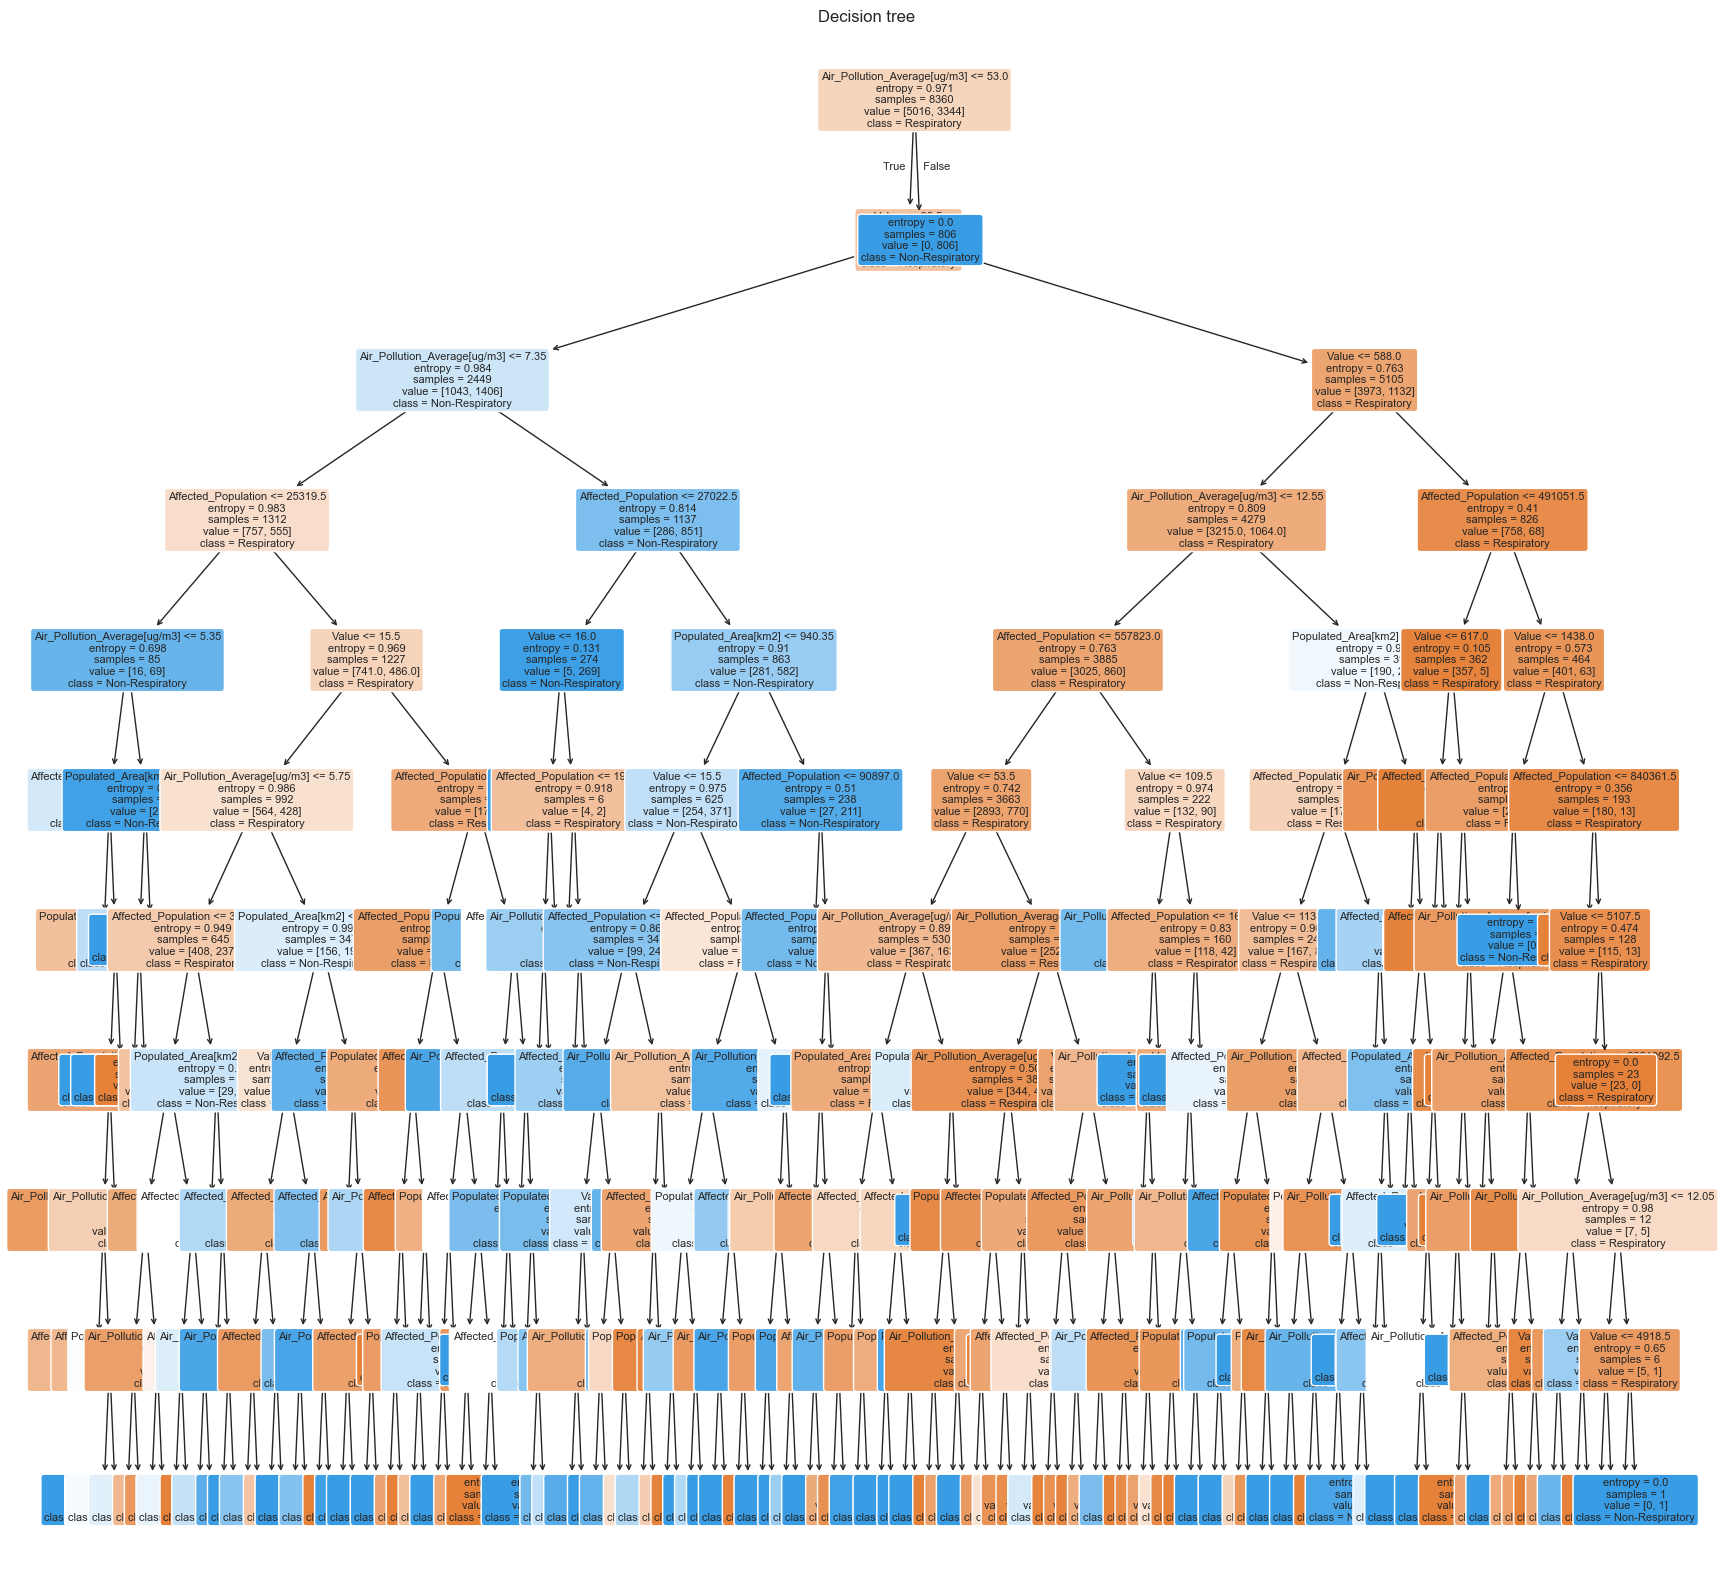

In [393]:
from sklearn import tree

# Final decision tree

clf=DecisionTreeClassifier(criterion = 'entropy', max_depth=10,random_state=42)

dtm=clf.fit(X_train,y_train)

plt.figure(figsize=(20,20))

tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Respiratory','Non-Respiratory'], rounded=True, fontsize=8)
plt.title('Decision tree')
plt.show()

##### b) Rede neuronal. Otimize a configuração da rede.

##### 1. Dividir o dataset:

In [394]:
features = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']

## Separar perdictors e target
X=df_grouped[features]
y=df_grouped['RespDisease'] # RespDisease is the target label

In [395]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
labelencode = LabelEncoder()
y=labelencode.fit_transform(y)

In [396]:
# Separar train e test
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123)

In [397]:
X_train.shape, X_test.shape

((7315, 4), (3135, 4))

In [398]:
# Aplicar standard scaller
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [399]:
nhidden=1

In [400]:
nn = MLPClassifier(hidden_layer_sizes=nhidden, activation='tanh', solver='lbfgs', max_iter=100, random_state=42)

In [401]:
nn.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=1, max_iter=100,
              random_state=42, solver='lbfgs')

In [402]:
#Validate the model
y_train_pred = nn.predict(X_train)
y_test_pred = nn.predict(X_test)
nn.score(X_test, y_test)

0.7926634768740032

In [403]:
print(confusion_matrix(y_test_pred, y_test))
target_names = ['Respiratory','Non-Respiratory']
print(classification_report(y_test, y_test_pred, target_names=target_names))

[[1727  487]
 [ 163  758]]
                 precision    recall  f1-score   support

    Respiratory       0.78      0.91      0.84      1890
Non-Respiratory       0.82      0.61      0.70      1245

       accuracy                           0.79      3135
      macro avg       0.80      0.76      0.77      3135
   weighted avg       0.80      0.79      0.79      3135



In [404]:
## or... from sklearn.metrics import accuracy_score
nn_train = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", nn_train)
nn_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", nn_test)

Train Accuracy: 0.7881066302118934
Test Accuracy: 0.7926634768740032


In [409]:
nhidden = [6,2]
nn = MLPClassifier(hidden_layer_sizes=nhidden, activation='tanh', solver='lbfgs', max_iter=100, random_state=42)

In [410]:
nn.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=[6, 2], max_iter=100,
              random_state=42, solver='lbfgs')

In [411]:
#Validate the model
y_train_pred = nn.predict(X_train)
y_test_pred = nn.predict(X_test)
nn.score(X_test, y_test)

0.8274322169059011

In [412]:
print(confusion_matrix(y_test_pred, y_test))
target_names = ['Respiratory','Non-Respiratory']
print(classification_report(y_test, y_test_pred, target_names=target_names))

[[1829  480]
 [  61  765]]
                 precision    recall  f1-score   support

    Respiratory       0.79      0.97      0.87      1890
Non-Respiratory       0.93      0.61      0.74      1245

       accuracy                           0.83      3135
      macro avg       0.86      0.79      0.80      3135
   weighted avg       0.85      0.83      0.82      3135



### Comentário:

2 camadas ocultas -> A primeira camada oculta tem 6 neurónios, a segunda tem 2 neurónios. - Melhora os resultados, a exatidão aumentou.

##### c) SVM. Otimize o kernel.

##### d) K-vizinhos-mais-próximos. Otimize o parâmetro K.

#### 3. Obtenha a média e o desvio padrão da Accuracy; Sensitivity; Specificity e F1 do atributo RespDisease com os modelos obtidos na alínea anterior.

#### 4. Verifique se existe diferença significativa no desempenho dos dois melhores modelos obtidos anteriormente (use um nível de significância de 5%). Identifique o modelo que apresenta o melhor desempenho.

#### 5. Compare os resultados dos modelos. Discuta em detalhe qual o modelo que apresentou melhor e pior desempenho de acordo com os critérios: Accuracy; Sensitivity; Specificity e F1.